In [1]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from operator import itemgetter
import os

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

import torchbearer
from torchbearer import Trial, metrics, Metric
from torchbearer.callbacks import Best, ModelCheckpoint

import optuna
from optuna.samplers import TPESampler, RandomSampler

import ipywidgets
from tqdm import tqdm

import gseapy as gp

import warnings
warnings.filterwarnings("ignore")

In [2]:
virus_metadata = pd.read_csv("../Data/Files/viruses_metadata.csv", header=0, sep=";")

virus_metadata_onco = virus_metadata[virus_metadata["isOncogenic"] == True].reset_index()
virus_metadata_nonco = virus_metadata[virus_metadata["isOncogenic"] == False].reset_index()

#dictionary containing a unquie mapping between name of the protein and a corresponding index
node_map_df = pd.read_csv("../Data/Files/node_map.csv")
node_map_dict = {k:(v-1) for k,v in zip(node_map_df["Prot"], node_map_df["Index"])}

biostr_df = pd.read_csv("../Data/data_BIOGRID/BIOGRID_homo_sapiens.nodes", sep=" ")
biostr_map = dict(zip(biostr_df["nodeID"], biostr_df["nodeSymbol"]))

In [119]:
vm1 = virus_metadata[virus_metadata['neigh_order']==1]

In [130]:
mapper = dict(zip(np.unique(vm1['family']),vt))

In [127]:
vt = ["dsDNA","ssRNA+","dsDNA","ssRNA+","ssRNA+","ssRNA+","ssRNA-","ssRNA+","ssDNA","ssRNA",
     "dsDNA","ssRNA+","dsDNA","ssRNA-","dsDNA","ssRNA-","ssDNA","ssRNA-","ssRNA+","ssRNA-","dsDNA",
     "ssRNA+","dsDNA","dsRNA","ssRNA(RT)","ssRNA+","ssRNA-0","ssRNA+","inc"]

In [132]:
vm1['VT']=vm1['family'].map(mapper)

In [160]:
vm1[vm1['isOncogenic']==False][["RNA" in v for v in vm1[vm1['isOncogenic']==False]['VT']]]['virus_short'].to_numpy().shape

(51,)

In [129]:
for i in range(29):
    print(np.unique(vm1['family'])[i],vt[i])

Adenoviridae dsDNA
Arteriviridae ssRNA+
Asfarviridae dsDNA
Bromoviridae ssRNA+
Caliciviridae ssRNA+
Coronaviridae ssRNA+
Filoviridae ssRNA-
Flaviviridae ssRNA+
Geminiviridae ssDNA
Hantaviridae ssRNA
Hepadnaviridae dsDNA
Hepeviridae ssRNA+
Herpesviridae dsDNA
Orthomyxoviridae ssRNA-
Papillomaviridae dsDNA
Paramyxoviridae ssRNA-
Parvoviridae ssDNA
Phenuiviridae ssRNA-
Picornaviridae ssRNA+
Pneumoviridae ssRNA-
Polyomaviridae dsDNA
Potyviridae ssRNA+
Poxviridae dsDNA
Reoviridae dsRNA
Retroviridae ssRNA(RT)
Togaviridae ssRNA+
Tospoviridae ssRNA-0
Virgaviridae ssRNA+
incertae sedis inc


# Dataset Loading

In [5]:
# files where all oncogenic viruses are used
top_dir = np.array(os.listdir("../Data/ClassificationDataALL_4vir/topology"))
print(top_dir)
top_dir_train = top_dir[[0,1]]
print(top_dir_train)
top_dir_pred = np.array(os.listdir("../Data/ClassificationDataALL_4vir/topology"))[[5]]
print(top_dir_pred)
top_dir_synt = [np.array(os.listdir("../Data/ClassificationData_4vir/Test_Synt_330Nonco"))[0]]
print(top_dir_synt)
top_dir_syntbstr = [np.array(os.listdir("../Data/ClassificationDataALL_4vir/Test_Synt_DistrSars/"))[0]]
print(top_dir_syntbstr)

['n' 'n1o' 'n2o' 'n3o' 'o' 'n1s' 'n1o1s' 'n2o1s' 'o1s']
['n' 'n1o']
['n1s']
['n1yn']
['n1yn']


In [3]:
def normalize_fix_nEntr(Xi, nentr=2000):
    for i in tqdm(range(len(Xi))):
        empty_provv = np.zeros(len(Xi[0]))
        empty_provv[np.argsort(Xi[i])[-nentr:]] = Xi[i][np.argsort(Xi[i])[-nentr:]]
        n_nz = empty_provv.nonzero()[0].shape[0]
        if n_nz==nentr:
            Xi[i]=empty_provv/sum(empty_provv)
        else:
            ind_provv = np.random.choice(np.where(empty_provv==0)[0], nentr-n_nz, replace=False)
            vals = np.random.rand(nentr-n_nz)
            vals = vals/sum(vals)*0.1
            Xi[i]=empty_provv/sum(empty_provv)*0.9
            Xi[i][ind_provv] = vals
    return Xi

In [6]:
#training samples
print("Loading Train and Val")
X = []
for t in top_dir_train:
    for i in tqdm(range(3000)):#os.listdir("../Data/ClassificationData_4vir/topology/"+t):
        X.append(np.loadtxt("../Data/ClassificationDataALL_4vir/topology_p/"+t+"/"+str(i)+".txt"))
X=np.array(X)

#training samples labels
label_dict = dict(zip(top_dir_train, [0,1]))

y = []
for t in top_dir_train:
    y.append([label_dict[t]]*3000)#len(os.listdir("../Data/ClassificationData_4vir/topology/"+t)))

y = np.concatenate(y)



Loading Train and Val


100%|███████████████████████████████████████| 3000/3000 [01:39<00:00, 30.06it/s]


In [7]:
X = normalize_fix_nEntr(X, nentr=2000)

100%|██████████████████████████████████████| 6000/6000 [00:28<00:00, 212.79it/s]


In [7]:
print("Loading Test")
# samples with sarscov2
X_pred = []
pred_len = []
for t in top_dir_pred:
    #plen = np.minimum(len(os.listdir("../Data/ClassificationData_4vir/topology/"+t)),200)
    #pred_len.append(plen)
    for i in tqdm(range(100)):#os.listdir("../Data/ClassificationData_4vir/topology/"+t):
        X_pred.append(np.loadtxt("../Data/ClassificationDataALL_4vir/topology/"+t+"/"+str(i)+".txt"))

X_pred = np.array(X_pred)
X_pred = normalize_fix_nEntr(X_pred)
print(X_pred.shape)

print("Loading Synt Test")
# samples with sarscov2
X_synt = []
synt_len = []
for t in top_dir_synt:
    #plen = np.minimum(len(os.listdir("../Data/ClassificationData_4vir/topology/"+t)),200)
    #pred_len.append(plen)
    for i in tqdm(range(100)):#os.listdir("../Data/ClassificationData_4vir/topology/"+t):
        X_synt.append(np.loadtxt("../Data/ClassificationData_4vir/Test_Synt_330Nonco/"+t+"/"+str(i)+".txt"))

X_synt = np.array(X_synt)
X_synt = normalize_fix_nEntr(X_synt)
print(X_synt.shape)

print("Loading SyntBSTR Test")
# samples with sarscov2
X_syntbstr = []
syntbstr_len = []
for t in top_dir_syntbstr:
    #plen = np.minimum(len(os.listdir("../Data/ClassificationData_4vir/topology/"+t)),200)
    #pred_len.append(plen)
    for i in tqdm(range(100)):#os.listdir("../Data/ClassificationData_4vir/topology/"+t):
        X_syntbstr.append(np.loadtxt("../Data/ClassificationDataALL_4vir/Test_Synt_DistrSars/"+t+"/"+str(i)+".txt"))

X_syntbstr = np.array(X_syntbstr)
X_syntbstr = normalize_fix_nEntr(X_syntbstr)
print(X_syntbstr.shape)

Loading Test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 222.42it/s]


(100, 19945)
Loading Synt Test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 216.83it/s]


(100, 19945)
Loading SyntBSTR Test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 287.94it/s]

(100, 19945)


# PERCEPTRON

## Dataset and Dataloaders Definition

In [8]:
class AdjacencyDataset(Dataset):
    """Apples Dataset"""

    def __init__(self, X, y=None, test=False):
        """
        Args:
        """
        self.test = test
        self.data = X
        self.labels = y
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        dat = self.data[idx]#np.array([self.data[idx].nonzero()[0], self.data[idx][self.data[idx].nonzero()[0]]])
        if self.test:
            return torch.from_numpy(dat).type(torch.FloatTensor)
        else:
            return [torch.from_numpy(dat).type(torch.FloatTensor), int(self.labels[idx])]
        

In [9]:
mydat_sars = AdjacencyDataset(X_pred, test=True)
mydat_synt = AdjacencyDataset(X_synt, test=True)
mydat_syntbstr = AdjacencyDataset(X_syntbstr, test=True)

sars_dataloader = DataLoader(mydat_sars, batch_size=10, shuffle=False, num_workers=0)
synt_dataloader = DataLoader(mydat_synt, batch_size=10, shuffle=False, num_workers=0)
syntbstr_dataloader = DataLoader(mydat_syntbstr, batch_size=10, shuffle=False, num_workers=0)

## Model

In [10]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(in_features=19945, out_features=2)
        self.drop = nn.Dropout(p=0.3)
        #self.lin2 = nn.Linear(in_features=200, out_features=50)
        #self.lin3 = nn.Linear(in_features=50, out_features=8)

    def forward(self, x):
        #x = self.lin1(torch.flatten(x, start_dim=1))
        x=self.lin1(x)
        return x

model1 = Model()
model1=model1.cpu()


In [11]:
def set_up_trial(X, ind):
    index_rem = np.loadtxt("../Data/MLRes/indexes/"+str(ind)+"_index.txt", dtype=int)
    index_rem = (index_rem[index_rem<(len(X)//2)])+(len(X)//2)

    X_test = X[index_rem]
    y_test = y[index_rem]
    X_train, X_val, y_train, y_val = train_test_split(X[np.delete(np.arange(len(X)), index_rem)], y[np.delete(np.arange(len(X)), index_rem)], test_size=0.1, random_state=42)
    
    mydat_train = AdjacencyDataset(X_train, y_train)
    mydat_val = AdjacencyDataset(X_val, y_val)
    mydat_test = AdjacencyDataset(X_test, y_test)

    train_dataloader = DataLoader(mydat_train, batch_size=20, shuffle=True, num_workers=0)
    val_dataloader = DataLoader(mydat_val, batch_size=20, shuffle=False, num_workers=0)
    test_dataloader = DataLoader(mydat_test, batch_size=20, shuffle=False, num_workers=0)
     
    check_last = ModelCheckpoint('checkpoints/check_last_'+str(i)+'.pth')
    
    model = Model()
    model = model1.cpu()
    
    trial_now = Trial(model,
                      optim.Adam(model1.parameters(), lr=5e-04), 
                      nn.CrossEntropyLoss(), 
                      metrics=["loss", "acc"],
                      callbacks=[check_last])
    
    trial_now = trial_now.load_state_dict(state_dict=torch.load("checkpoints/check_last_"+str(ind)+".pth"))
   
    trial_now.with_generators(train_generator=train_dataloader, 
                              val_generator=val_dataloader, 
                              test_generator=test_dataloader)
    
    my_trial_now = trial_now.run(epochs=600, verbose=1)
    
    return trial_now, my_trial_now

In [12]:
trial, mytrial = set_up_trial(X, 78)

100%|##########| 600/600 [00:00<?, ?it/s]

In [13]:
trial.with_test_generator(sars_dataloader)
sars_pred = np.argmax(trial.predict().detach().numpy(),axis=1)

0/1(p):   0%|          | 0/19 [00:00<?, ?it/s]

In [485]:
conf_mat[0].sum()

311

In [487]:
spec = conf_mat[0,0]/(conf_mat[0].sum())
sens = conf_mat[1,1]/(conf_mat[1].sum())
prior = 0.1

In [491]:
tu = np.prod([sens]*sum(sars_pred)+[1-sens]*(len(sars_pred)-sum(sars_pred)))#*prior

td = np.prod([1-spec]*sum(sars_pred)+[spec]*(len(sars_pred)-sum(sars_pred)))#*(1-prior)

tu/(tu+td)

1.0

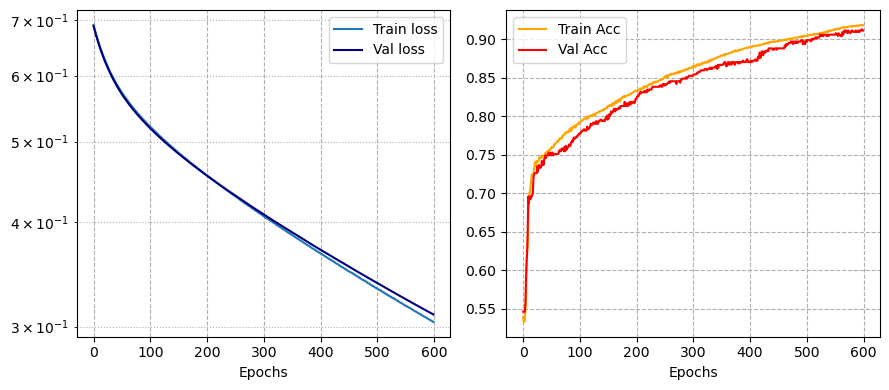

In [345]:
__, ax = plt.subplots(1,2,figsize=(9,4))

ax[0].semilogy([mt["loss"] for mt in mt_now], label="Train loss", color="C0")
ax[0].semilogy([mt["val_loss"] for mt in mt_now], label="Val loss", color="navy")

ax[1].plot([mt["acc"] for mt in mt_now], label="Train Acc", color="orange")
ax[1].plot([mt["val_acc"] for mt in mt_now], label="Val Acc", color="red")

[axi.set_xlabel("Epochs") for axi in ax]
[axi.legend() for axi in ax]
[axi.grid(ls="--") for axi in ax]
ax[0].grid(which="minor", ls=":")
plt.tight_layout()

In [473]:
def plot_confusion_matrix(trial, which="val"):
    if which=="val":
        val_pred=np.argmax(trial.predict(data_key=torchbearer.VALIDATION_DATA).detach().numpy(),axis=1)
        val_true=[v[1] for v in trial.state.data["validation_generator"].dataset]
        title="VALIDATION CONFUSION MATRIX"
    elif which=="test":
        val_pred=np.argmax(trial.predict(data_key=torchbearer.TEST_DATA).detach().numpy(),axis=1)
        val_true=[v[1] for v in trial.state.data["test_generator"].dataset]
        title="TEST CONFUSION MATRIX"
    else:
        raise ValueError("which should be either val or test")
    
    confM_val = confusion_matrix(y_true = val_true, y_pred = val_pred, labels=np.arange(2))

    plt.figure(figsize=(6,6))
    sns.heatmap(confM_val, annot=True, fmt="g", cbar=False, cmap="magma")
    plt.title(title, weight="bold")
    plt.ylabel("True labels")
    plt.xlabel("Predicted labels")
    plt.tight_layout()
    
    return confM_val

In [77]:
biostr_df = pd.read_csv("../Data/data_BIOGRID/BIOGRID_homo_sapiens.nodes", sep=" ")
biostr_map = dict(zip(biostr_df["nodeID"], biostr_df["nodeSymbol"]))

def plot_weights(trial, ref_df):
    weights = trial.state["model"].lin1.weight.data.detach().numpy()
    weights = np.array([weights[i]/max(weights[i]) for i in range(len(weights))])
    
    weigh_df = ref_df.copy()

    for i in range(2):
        weigh_df["W"+str(i)] = weights[i]
    weigh_df["std"] = np.abs(weigh_df["W0"]-weigh_df["W1"])
    
    plt.figure(figsize=(16,3))
    sns.heatmap(weights)
    plt.title("PERCEPTRON WEIGHTS HEATMAP", fontweight="bold")
    plt.xlabel("Node ID")
    plt.ylabel("Label")
    plt.tight_layout()
    
    return weigh_df

In [73]:
def plot_weights_heatmap(weigh_df):
    gauss = gaussian_kde(weigh_df[["nodeID","W1"]].T.to_numpy())
    kde = gaussian_kde(weigh_df[["nodeID","W1"]].T.to_numpy())
    density_1 = kde(weigh_df[["nodeID","W1"]].T.to_numpy())
    gauss = gaussian_kde(weigh_df[["nodeID","W0"]].T.to_numpy())
    kde = gaussian_kde(weigh_df[["nodeID","W0"]].T.to_numpy())
    density_0 = kde(weigh_df[["nodeID","W0"]].T.to_numpy())

    _, ax = plt.subplots(1,2, figsize=(12,4))

    ax[0].scatter(weigh_df["nodeID"], weights[0], c=density, cmap='viridis', s=0.1)
    ax[0].set_title("WEIGHTS LABEL 0", fontweight="bold")
    ax[0].set_xlabel("Entry position")
    ax[0].set_ylabel("Weight value")
    ax[1].scatter(weigh_df["nodeID"], weights[1], c=density, cmap='viridis', s=0.1)
    ax[1].set_title("WEIGHTS LABEL 1", fontweight="bold")
    ax[1].set_xlabel("Entry position")
    ax[1].set_ylabel("Weight value")
    plt.tight_layout()

0/1(p):   0%|          | 0/29 [00:00<?, ?it/s]

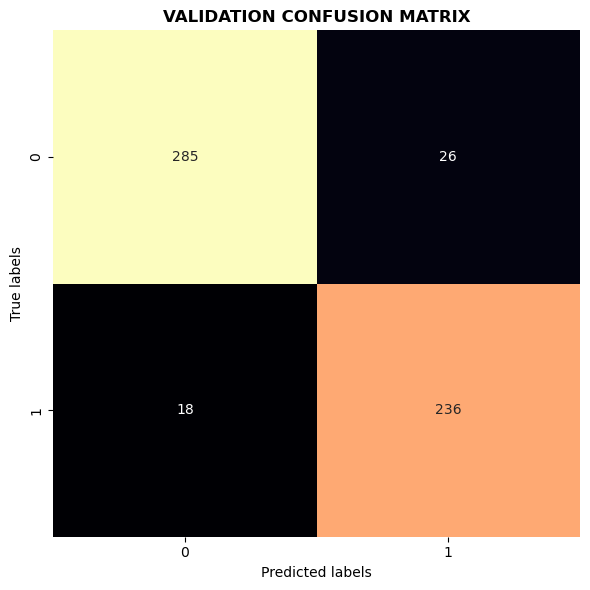

In [474]:
conf_mat = plot_confusion_matrix(trial, "val")

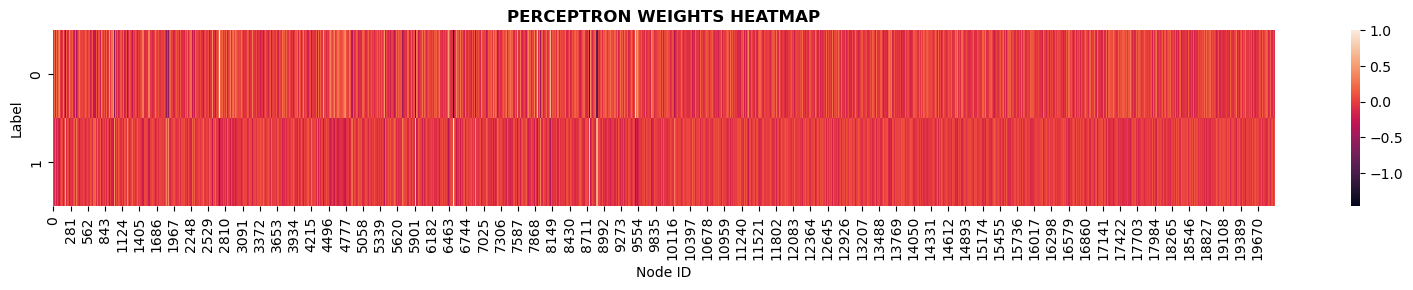

In [78]:
weigh_df = plot_weights(trial, ref_df=biostr_df)

In [89]:
trial_2.with_test_generator(synt_dataloader)
synt_pred = np.argmax(trial_2.predict().detach().numpy(),axis=1)

trial_2.with_test_generator(syntbstr_dataloader)
syntbstr_pred = np.argmax(trial_2.predict().detach().numpy(),axis=1)

trial_2.with_test_generator(test_dataloader)
test_pred = np.argmax(trial_2.predict().detach().numpy(),axis=1)

trial_2.with_test_generator(sars_dataloader)
sars_pred = np.argmax(trial_2.predict().detach().numpy(),axis=1)

0/1(p):   0%|          | 0/20 [00:00<?, ?it/s]

0/1(p):   0%|          | 0/20 [00:00<?, ?it/s]

0/1(p):   0%|          | 0/20 [00:00<?, ?it/s]

0/1(p):   0%|          | 0/20 [00:00<?, ?it/s]

In [93]:
accuracy_score(test_pred, y_test)

0.7461139896373057

## Intersection analysis

In [12]:
def custom_intersection(arr):
    inters = np.intersect1d(arr[0],arr[1])
    for i in range(2,len(arr)):
        inters = np.intersect1d(inters, arr[i])
    return inters

In [80]:
top_50=[]
w0_50=[]
w1_50=[]
for a in [28,43,44,67,75,77,78,90]:
    top_50.append(pd.read_csv("../Data/MLRes/to_50_"+str(a)+".csv").to_numpy())
    w0_50.append(pd.read_csv("../Data/MLRes/w0_50_"+str(a)+".csv").to_numpy())
    w1_50.append(pd.read_csv("../Data/MLRes/w1_50_"+str(a)+".csv").to_numpy())

In [81]:
custom_intersection([w0_50[i] for i in [0,1,2,3,4,5,7]]).shape

(18,)

In [82]:
print((", ").join(custom_intersection([top_50[i] for i in [0,1,2,3,4,5,7]])))

CBX3, CTBP1, DYRK1B, FBXO3, GATA4, HIPK2, HIST1H2BG, HIST2H3A, LZTS2, MECP2, MYB, MYBL1, NCK2, NKX2-1, NKX2-5, NLK, NPPA, NPSR1, PPM1D, RASSF5, RGMA, SENP1, SENP2, SKI, SP100, TP53INP1, TRIM29, ZBTB4


## Top 50 production

In [38]:
for i in [67,75]:
    tr_now, mt_now = set_up_trial(X, i)
    weights = tr_now.state["model"].lin1.weight.detach().numpy()
    weights = np.array([weights[i]/max(weights[i]) for i in range(len(weights))])

    weigh_df = biostr_df.copy()

    for j in range(2):
        weigh_df["W"+str(j)] = weights[j]
    weigh_df["std"] = np.abs(weigh_df["W0"]-weigh_df["W1"])

    weigh_df.sort_values("W1", ascending=False).head(50)["nodeSymbol"].to_csv("../Data/MLRes/w1_50_"+str(i)+".csv", index=False)

100%|##########| 600/600 [00:00<?, ?it/s]

100%|##########| 600/600 [00:00<?, ?it/s]

## Trials production

In [ ]:
biostr_df = pd.read_csv("../Data/data_BIOGRID/BIOGRID_homo_sapiens.nodes", sep=" ")
biostr_map = dict(zip(biostr_df["nodeID"], biostr_df["nodeSymbol"]))

synt_pred_list, syntbstr_pred_list, test_pred_list, sars_pred_list = [],[],[],[]
top_50 = []

for i in [75,77,78,90]:
    index_rem = np.loadtxt("../Data/MLRes/indexes/"+str(i)+"_index.txt", dtype=int)
    index_rem = (index_rem[index_rem<(len(X)//2)])+(len(X)//2)

    X_test = X[index_rem]
    y_test = y[index_rem]
    print(X_test.shape)
    print(np.mean(y_test)==1)

    X_train, X_val, y_train, y_val = train_test_split(X[np.delete(np.arange(len(X)), index_rem)], y[np.delete(np.arange(len(X)), index_rem)], test_size=0.1, random_state=42)

    print(X_train.shape)
    print(X_val.shape)
    
    mydat_train = AdjacencyDataset(X_train, y_train)
    mydat_val = AdjacencyDataset(X_val, y_val)
    mydat_test = AdjacencyDataset(X_test, y_test)

    train_dataloader = DataLoader(mydat_train, batch_size=20, shuffle=True, num_workers=0)
    val_dataloader = DataLoader(mydat_val, batch_size=20, shuffle=False, num_workers=0)
    test_dataloader = DataLoader(mydat_test, batch_size=20, shuffle=False, num_workers=0)
    
    model1 = Model()
    model1 = model1.cpu()
    
    check_last = ModelCheckpoint('checkpoints/check_last_'+str(i)+'.pth')

    trial_2 = Trial(model1,
                     optim.Adam(model1.parameters(), lr=5e-04), 
                     nn.CrossEntropyLoss(), 
                     metrics=["loss", "acc"],
                     callbacks=[check_last])

    trial_2.with_generators(train_generator=train_dataloader, 
                      val_generator=val_dataloader, 
                      test_generator=test_dataloader)#val67_dataloader)

    mytrial = trial_2.run(epochs=600, verbose=1)
    
    
    weights = model1.lin1.weight.data.detach().numpy()
    weights = np.array([weights[i]/max(weights[i]) for i in range(len(weights))])
    
    weigh_df = biostr_df.copy()

    for j in range(2):
        weigh_df["W"+str(j)] = weights[j]
    weigh_df["std"] = np.abs(weigh_df["W0"]-weigh_df["W1"])
    
    weigh_df.sort_values("std", ascending=False).head(50)["nodeSymbol"].to_csv("to_50_"+str(i)+".csv", index=False)

## Combinations analysis

In [81]:
leen=[]
for cc in combinations(np.arange(8), 7):
    inter_len=[]
    for c in list(combinations(cc, 4)):
        inter_len.append(custom_intersection([top_50[i] for i in c]).shape[0])
    print(cc, np.mean(inter_len))
    leen.append(np.mean(inter_len))

(0, 1, 2, 3, 4, 5, 6) 24.457142857142856
(0, 1, 2, 3, 4, 5, 7) 34.285714285714285
(0, 1, 2, 3, 4, 6, 7) 26.82857142857143
(0, 1, 2, 3, 5, 6, 7) 22.62857142857143
(0, 1, 2, 4, 5, 6, 7) 22.571428571428573
(0, 1, 3, 4, 5, 6, 7) 22.37142857142857
(0, 2, 3, 4, 5, 6, 7) 22.857142857142858
(1, 2, 3, 4, 5, 6, 7) 22.4


In [74]:
inters_df=pd.DataFrame()

In [82]:
inters_df["4 elements"]=leen

In [83]:
inters_df

,6 elements,5 elements,4 elements
0,15.142857,19.571429,24.457143
1,29.857143,31.904762,34.285714
2,18.000000,22.238095,26.828571
3,12.000000,17.142857,22.628571
4,11.857143,17.000000,22.571429
5,11.857143,16.904762,22.371429
6,12.571429,17.476190,22.857143
7,11.857143,16.904762,22.400000


In [84]:
_len=[]
for cl in [4,5,6]:
    inter_len=[]
    for c in list(combinations(np.arange(8), cl)):
        #print(c, custom_intersection([top_50[i] for i in c]).shape)
        inter_len.append(custom_intersection([top_50[i] for i in c]).shape[0])
    _len.append(np.mean(inter_len))

In [90]:
inters_df.loc[8] = _len 

In [103]:
inters_df.index = ["EB","HBC","HC1","HV8P","PV16","PV18","PV5","TL1"][::-1]+["None"]

In [102]:
["EB","HBC","HC1","HV8P","PV16","PV18","PV5","TL1"][::-1]+["None"]

['TL1', 'PV5', 'PV18', 'PV16', 'HV8P', 'HC1', 'HBC', 'EB', 'None']

In [106]:
print(inters_df.T.to_latex(float_format="%.1f" ))

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &  TL1 &  PV5 &  PV18 &  PV16 &  HV8P &  HC1 &  HBC &   EB &  None \\
\midrule
6 elements & 15.1 & 29.9 &  18.0 &  12.0 &  11.9 & 11.9 & 12.6 & 11.9 &  24.8 \\
5 elements & 19.6 & 31.9 &  22.2 &  17.1 &  17.0 & 16.9 & 17.5 & 16.9 &  19.9 \\
4 elements & 24.5 & 34.3 &  26.8 &  22.6 &  22.6 & 22.4 & 22.9 & 22.4 &  15.4 \\
\bottomrule
\end{tabular}



# Random Forest

In [8]:
def random_tree_MINE(X, ind, max_depth, n_estimators, min_samples_split, min_samples_leaf, max_features, criterion, what_return="score"):
    num_features = X.shape[1]
    
    index_rem = np.loadtxt("../Data/MLRes/indexes/"+str(ind)+"_index.txt", dtype=int)
    index_rem = (index_rem[index_rem<(len(X)//2)])+(len(X)//2)

    X_test = X[index_rem]
    y_test = y[index_rem]
    
    X_train, X_val, y_train, y_val = train_test_split(X[np.delete(np.arange(len(X)), index_rem)], y[np.delete(np.arange(len(X)), index_rem)], test_size=0.1, random_state=42)

    # Create a Random Forest classifier
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators,
                                           max_depth=max_depth, 
                                           min_samples_leaf=min_samples_leaf, 
                                           min_samples_split=min_samples_split,
                                           max_features=max_features,
                                           criterion=criterion
    )

    # Fit the classifier to the input data
    rf_classifier.fit(X_train, y_train)

    y_val_pred = rf_classifier.predict(X_val)
    y_train_pred = rf_classifier.predict(X_train)
    if what_return=="score":
        return accuracy_score(y_val, y_val_pred)
    else:
        
        # Calculate the accuracy of the model on the training data
        train_accuracy = accuracy_score(y_train, y_train_pred)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        # Classify the new sample
        predicted_class = rf_classifier.predict(X_test)
        
        importance_scores = rf_classifier.feature_importances_

        return {"Model": rf_classifier,
                "train_pred": y_train_pred,
                "train_true": y_train,
                "train_accuracy": train_accuracy,
                "val_pred": y_val_pred,
                "val_true": y_val,
                "val_accuracy": val_accuracy,
                "test_pred": predicted_class,
                "scores": importance_scores}

In [10]:
scores_list = []

for i in [28,43,44,67,75,77,78,90]:
    print("Random forest for", i)
    result = random_tree_MINE(X=X,
                              ind=i,
                              n_estimators=100,
                              max_depth=None, 
                              min_samples_split=2, 
                              min_samples_leaf=1,
                              max_features="sqrt",
                              criterion="entropy",
                              what_return="all")
    #sars_pred = result['Model'].predict(X_pred)
    #synt_pred = result['Model'].predict(X_synt)
    scores_list.append(biostr_df["nodeSymbol"][result['scores'].argsort()[::-1]][:50].to_numpy())
    #print("%.3f & %.3f & %.3f & %.3f & %.3f" %(result['train_accuracy'], result['val_accuracy'], result['test_pred'].mean(), sars_pred.mean(), synt_pred.mean()))

Random forest for 28
Random forest for 43
Random forest for 44
Random forest for 67
Random forest for 75
Random forest for 77
Random forest for 78
Random forest for 90


In [15]:
print((", ").join(custom_intersection([scores_list[i] for i in [0,1,2,3,4,5,7]])))

CBX3, CBX4, CTBP1, DYRK1B, HIPK2, HIST1H2BG, HIST1H3A, HIST2H2BE, MECP2, MYB, NKX2-1, NLK, NTRK1, SENP1, SP100, SUMO2


In [97]:
np.savetxt(X=custom_intersection([scores_list[i] for i in [0,1,2,3,4,5,7]]), fname="../Data/ClassificationData_4vir/RF_inters.txt", fmt="%s")

In [87]:
scores_df = pd.DataFrame(np.unique(np.concatenate(scores_list), return_counts=True)).T
print((", ").join(scores_df[scores_df[1]>6][0].to_numpy()))

CDH1, CTBP1, DYRK1B, HIPK2, HIST1H2AC, HIST1H2BG, HIST1H3A, HIST2H2BE, MECP2, MYB, NLK, NTRK1, SENP1, SUMO2


In [102]:
result = random_tree_MINE(X=X,
                          ind=43,
                          n_estimators=100,
                          max_depth=None, 
                          min_samples_split=2, 
                          min_samples_leaf=1,
                          max_features="sqrt",
                          criterion="entropy",
                          what_return="all")

In [103]:
y_val_pred = result["val_pred"]
y_test_pred = result["test_pred"]

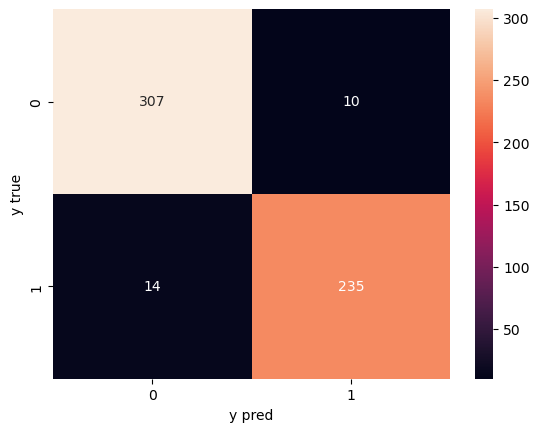

In [107]:
sns.heatmap(confusion_matrix(y_pred=result["val_pred"], y_true=result["val_true"]), annot=True, fmt="d")
plt.xlabel("y pred")
plt.ylabel("y true")
plt.show()

In [116]:
scores_df = biostr_df.copy()
scores_df["scores"] = result["scores"]
scores_df.sort_values("scores", ascending=False).head(20)

,nodeID,nodeLabel,nodeSymbol,scores
3150,3150,113945,HIST2H2BE,0.008538
427,427,110969,NTRK1,0.006316
4073,4073,118815,HIPK2,0.005745
6560,6560,119685,NLK,0.005620
6432,6432,112936,NKX2-1,0.005295
8578,8578,123000,NANOG,0.004961
7588,7588,113946,HIST1H3A,0.004847
4710,4710,109269,H2AFZ,0.004704
6910,6910,118930,SENP1,0.004407
6535,6535,110368,MECP2,0.004232


In [54]:
most_imp_RF

array(['CTBP1', 'AXIN1', 'MYC', 'HIPK2', 'NTRK1', 'HIST1H2BN',
       'HIST1H2BK', 'CDH1', 'HIST1H3A', 'MECP2', 'HIST1H2BG', 'HIST2H2BE',
       'DAXX', 'NLK', 'DYRK1B', 'PIAS1', 'CREB1', 'H2BFS', 'TP73', 'RPN2',
       'SENP1', 'CBX4', 'KAT5', 'H2AFZ', 'H2AFY', 'NKX2-1', 'RBBP5',
       'CDH2', 'HMGA1', 'PML', 'MAPK1', 'TMEM17', 'HIST1H2BH', 'RBPJ',
       'SKI', 'SUMO2', 'SP100', 'UBE2I', 'RPS5', 'HDAC8', 'MLH1',
       'H2AFB1', 'SMARCA5', 'UBE2G2', 'HIST1H2BD', 'TP53INP1', 'POLR2L',
       'MYB', 'HIST2H3PS2', 'TPT1'], dtype=object)

In [179]:
np.savetxt(X=np.intersect1d(most_imp_PERC, most_imp_RF), fname="../Data/ClassificationData_4vir/inters.txt", fmt="%s")

In [180]:
np.savetxt(X=most_imp_PERC, fname="../Data/ClassificationData_4vir/PERC.txt", fmt="%s")

In [184]:
enr_inters = gp.enrichr(gene_list="../Data/ClassificationData_4vir/RF.txt", # or "./tests/data/gene_list.txt",
                          gene_sets=['KEGG_2021_Human'],
                          organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                          outdir=None # don't write to disk
                          )

In [ ]:
enr_inters.results.sort_values("Adjusted P-value")

In [160]:
def objective(trial):

    # set the range of the transformations to apply to the image
    hyperparameters = [
        #trial.suggest_int("n_estimators", 50,150),
        trial.suggest_int("max_depth", 1, 100),
        trial.suggest_int("min_samples_split", 2,10),
        trial.suggest_int("min_samples_leaf", 1,10),
        trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"])
    ]
    
    return random_tree_MINE(X=X,
                            ind=77,
                            n_estimators = 100,
                            max_depth=hyperparameters[0], 
                            min_samples_split=hyperparameters[1], 
                            min_samples_leaf=hyperparameters[2],
                            max_features=hyperparameters[3],
                            criterion = hyperparameters[4])

pruner: optuna.pruners.BasePruner = optuna.pruners.NopPruner()
sampler = TPESampler(seed=12345)
study = optuna.create_study(study_name="random tree", direction="maximize", pruner=pruner, sampler=sampler)
optuna.logging.set_verbosity(optuna.logging.INFO)
study.optimize(objective, n_trials=10)


print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("   Max IoU: {}".format(trial.value))

print("   Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-06-05 15:18:03,019] A new study created in memory with name: random tree
[I 2023-06-05 15:18:06,862] Trial 0 finished with value: 0.9411764705882353 and parameters: {'max_depth': 93, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2', 'criterion': 'entropy'}. Best is trial 0 with value: 0.9411764705882353.
[I 2023-06-05 15:18:10,717] Trial 1 finished with value: 0.946524064171123 and parameters: {'max_depth': 75, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'criterion': 'log_loss'}. Best is trial 1 with value: 0.946524064171123.
[I 2023-06-05 15:18:14,532] Trial 2 finished with value: 0.9429590017825312 and parameters: {'max_depth': 81, 'min_samples_split': 9, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 1 with value: 0.946524064171123.
[I 2023-06-05 15:18:18,339] Trial 3 finished with value: 0.9358288770053476 and parameters: {'max_depth': 44, 'min_samples_split': 8, 'min_samples_leaf': 10, 'ma

Number of finished trials: 10
Best trial:
   Max IoU: 0.9572192513368984
   Params: 
    max_depth: 82
    min_samples_split: 6
    min_samples_leaf: 9
    max_features: log2
    criterion: entropy


In [38]:
res_df = pd.DataFrame({"Prot": node_map_df.loc[sorted_indices]["Prot"], "Score": np.sort(importance_scores)[::-1]})
res_df[res_df["Score"]>1e-3]

,Prot,Score
9317,CDH6,0.002634
2194,ATRX,0.002410
9010,APC2,0.002408
9318,CDH9,0.002311
8946,FAM171B,0.002292
...,...,...
7950,SCEL,0.001016
8658,SBSN,0.001010
8767,EPS8L1,0.001008
1206,HIST2H3PS2,0.001004


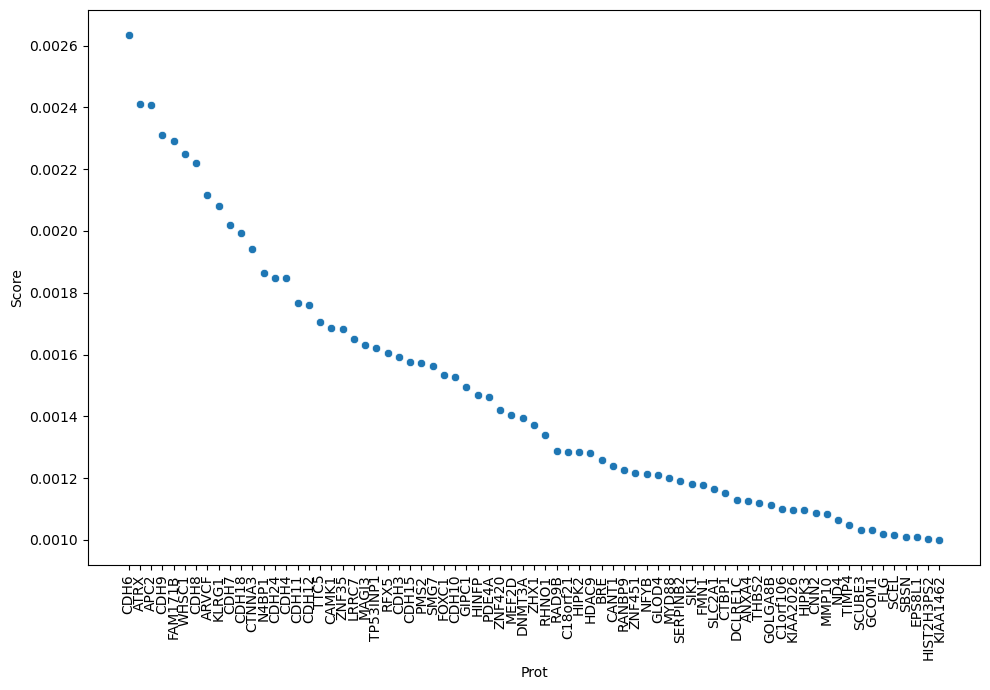

In [39]:
plt.figure(figsize=(10,7))
sns.scatterplot(data=res_df[res_df["Score"]>1e-3], x="Prot", y="Score")
plt.xticks(rotation=90)
plt.tight_layout()

# Enrichment

In [103]:
gp.get_library_name()

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'ChEA_2022',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019',
 'Descartes_Cell_Types_and_Tissue_2021',
 'Diabetes_Perturbations_GEO_2022',
 'DisGeNET',
 'Disease_

In [104]:
enr_inters = gp.enrichr(gene_list="../Data/ClassificationData_4vir/RF_inters.txt", # or "./tests/data/gene_list.txt",
                          gene_sets=['KEGG_2021_Human','GO_Molecular_Function_2023',],
                          organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                          outdir=None # don't write to disk
                          )

In [116]:
enr_inters

In [105]:
enr_inters.results.sort_values("Adjusted P-value").head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
19,GO_Molecular_Function_2023,Double-Stranded Methylated DNA Binding (GO:001...,1/5,0.002997,0.025971,0,0,454.181818,2638.914119,MECP2
18,GO_Molecular_Function_2023,deSUMOylase Activity (GO:0016929),1/5,0.002997,0.025971,0,0,454.181818,2638.914119,SENP1
17,GO_Molecular_Function_2023,Protein Tyrosine Kinase Activity (GO:0004713),2/99,0.001550,0.025971,0,0,41.012371,265.331124,NTRK1;HIPK2
20,GO_Molecular_Function_2023,Neurotrophin Binding (GO:0043121),1/7,0.004193,0.027255,0,0,302.757576,1657.396457,NTRK1
21,GO_Molecular_Function_2023,DNA-binding Transcription Factor Binding (GO:0...,2/282,0.011911,0.049496,0,0,14.077143,62.366161,CTBP1;HIPK2
26,GO_Molecular_Function_2023,Ubiquitin-Like Protein Peptidase Activity (GO:...,1/32,0.019037,0.049496,0,0,58.524927,231.838999,SENP1
25,GO_Molecular_Function_2023,Adenyl Nucleotide Binding (GO:0030554),1/31,0.018447,0.049496,0,0,60.478788,241.482494,CTBP1
24,GO_Molecular_Function_2023,methyl-CpG Binding (GO:0008327),1/29,0.017266,0.049496,0,0,64.805195,263.043544,MECP2
23,GO_Molecular_Function_2023,Protein Serine/Threonine Kinase Activity (GO:0...,2/342,0.017183,0.049496,0,0,11.557647,46.968582,DYRK1B;HIPK2
22,GO_Molecular_Function_2023,NAD Binding (GO:0051287),1/26,0.015493,0.049496,0,0,72.592727,302.520344,CTBP1


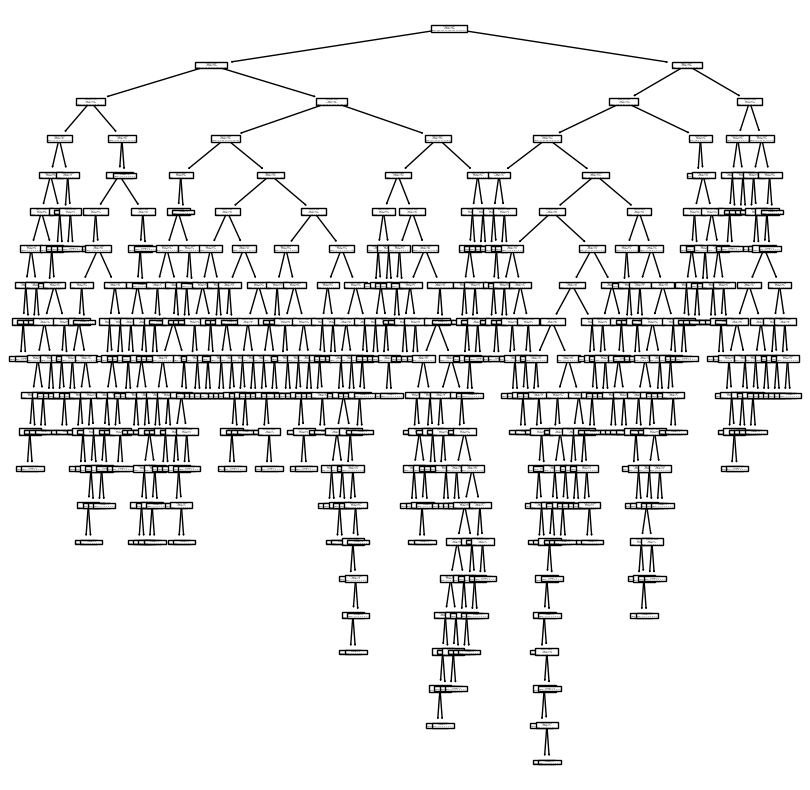

In [113]:
from sklearn import tree
# Extract the individual decision tree
decision_tree = rf_classifier.estimators_[0]

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the decision tree
tree.plot_tree(decision_tree, ax=ax)

# Show the plot
plt.show()